Dataset available here: https://www.kaggle.com/xhlulu/panda-resized-train-data-512x512

In [1]:
import os, sys, json

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [3]:
import matplotlib.pyplot as plt

import cv2, tifffile, imagecodecs

import skimage.io #be careful - only version >= 0.17.2 fit

from PIL import Image
from skimage.transform import resize, rescale

In [4]:
skimage.__version__

'0.17.2'

In [5]:
from tqdm.notebook import tqdm

In [6]:
from panda_bvv_config import *

### 0.Masks zoom ###

In [9]:
prime_trains[:3]

['0587586b10cc3417c3c3607102b3f720.tiff',
 '031f5ef5b254fbacd6fbd279ebfe5cc0.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb.tiff']

In [10]:
prime_masks[:3]

['0587586b10cc3417c3c3607102b3f720_mask.tiff',
 '031f5ef5b254fbacd6fbd279ebfe5cc0_mask.tiff',
 '00928370e2dfeb8a507667ef1d4efcbb_mask.tiff']

In [19]:
green_mask = os.path.join(train_path, '00928370e2dfeb8a507667ef1d4efcbb.tiff')
green_biopsy = skimage.io.MultiImage(green_mask)
gb0 = green_biopsy[0]
gb1 = green_biopsy[1]
gb2 = green_biopsy[2]

In [20]:
green_mask = os.path.join(mask_path, '00928370e2dfeb8a507667ef1d4efcbb_mask.tiff')
green_biopsy = skimage.io.MultiImage(green_mask)
gbm0 = green_biopsy[0]
gbm1 = green_biopsy[1]
gbm2 = green_biopsy[2]

In [24]:
print(gb0.shape, gbm0.shape)

(36352, 10752, 3) (36352, 10752, 3)


In [22]:
print(gb1.shape, gbm1.shape)

(9088, 2688, 3) (9088, 2688, 3)


In [23]:
print(gb2.shape, gbm2.shape)

(2272, 672, 3) (2272, 672, 3)


#### 1. ISUP grade ####

In [18]:
#train_labels.loc[train_labels.isup_grade == 0].head(30)
#head(30)
#= pd.read_csv(os.path.join(base_path, 'train.csv'))

In [21]:
file_name = '006f6aa35a78965c92fffd1fbd53a058.tiff'

In [22]:
train_labels.isup_grade.loc[train_labels.image_id == file_name.split('.')[0]]

17    3
Name: isup_grade, dtype: int64

#### 2. Biopsy mask ####

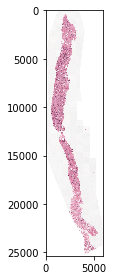

In [9]:
green_file = os.path.join(original_train_path, '0018ae58b01bdadc8e347995b69f99aa.tiff')
green_biopsy = skimage.io.MultiImage(green_file)
gb0 = green_biopsy[0]
gb1 = green_biopsy[1]
gb2 = green_biopsy[2]
#image_0 = Image.fromarray(img, mode='RGB'))


skimage.io.imshow(green_biopsy[0])

In [10]:
gb0[5000, 100]

array([248, 248, 248], dtype=uint8)

In [16]:
print(gb1.nbytes)

223838208


In [19]:
g_f = os.path.join(resized_train_path, '046b35ae95374bfb48cdca8d7c83233f.png')
g_b = skimage.io.imread(g_f)

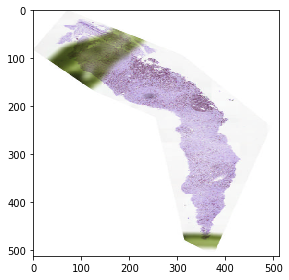

In [20]:
skimage.io.imshow(g_b)

In [ ]:
#cnts - this is a list of contours, each contour is a polygon
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
len(cnts)

In [ ]:
def get_biopsy_square(pca_cv):
    """
    this function calculates ratios of biopsy square to sample square
    """
    total = pca_cv.shape[0]*pca_cv.shape[1]
    temp_gray = cv2.cvtColor(pca_cv, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(temp_gray,(5,5),0)
    
    #we calculate binary squares ratio of biopsy square to total image square
    thresh_simple = cv2.threshold(temp_gray,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]
    binary_ratio = cv2.countNonZero(thresh_simple)/total
    
    #we calculate blur squares ratio: filtered image with a 5x5 gaussian kernel to remove the noise, then ratio of biopsy square to total image square
    thresh_blur = cv2.threshold(blur,0,255,cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]
    gaussian_ratio = cv2.countNonZero(thresh_blur)/total
    

In [172]:
gb1.shape

(2944, 1472, 3)

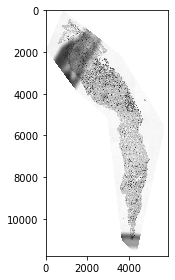

In [259]:
gbg = cv2.cvtColor(gb0, cv2.COLOR_BGR2GRAY)
skimage.io.imshow(gbg)

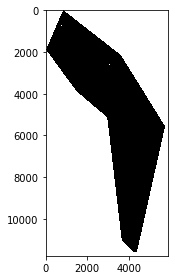

In [260]:
ret, wthr = cv2.threshold(gbg, 250, 255, 0)
skimage.io.imshow(wthr)

In [262]:
(1 -(np.sum(np.array(wthr)))/(wthr.shape[0] * wthr.shape[1]*255))*10000//100/100

0.3513897497397064

In [ ]:
#!: w, b prefixes - for background color

In [57]:
wcontours, whierarchy = cv2.findContours(wthr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

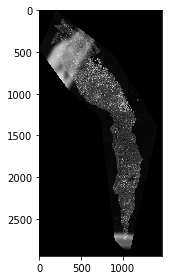

In [44]:
inv = cv2.bitwise_not(gbg)
skimage.io.imshow(inv)

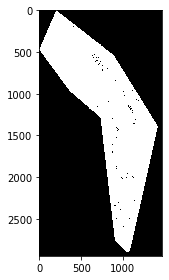

In [72]:
bret, bthr = cv2.threshold(inv, 0, 255, 0)
skimage.io.imshow(bthr)

In [59]:
bcontours, bhierarchy = cv2.findContours(bthr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [65]:
bcontours[:2]

[array([[[1016, 2878]],
 
        [[1016, 2879]],
 
        [[1017, 2879]]], dtype=int32),
 array([[[1008, 2870]],
 
        [[1008, 2871]],
 
        [[1009, 2871]]], dtype=int32)]

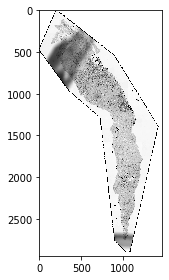

In [62]:
skimage.io.imshow(cv2.drawContours(gbg, bcontours, -1, (0,255,0), 3))

In [43]:
gbg[0, 0]

255

In [38]:
gb_con = cv2.findContours(gbg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#skimage.io.ims.shape
cnts = gb_con[0] if len(gb_con) == 2 else gb_con[1]
len(cnts)

1

In [39]:
cnts

[array([[[   0,    0]],
 
        [[   0, 2943]],
 
        [[1471, 2943]],
 
        [[1471,    0]]], dtype=int32)]

In [414]:
#tile constants

inp_image = gb0

tile_square_yside = 250
tile_square_xside = 170
tile_square_pixels = tile_square_yside*tile_square_xside
transform_ratios = [2.0, 3.0, 5.0, 6.0, 7.0]
ytiles = inp_image.shape[0]//tile_square_yside
xtiles = inp_image.shape[1]//tile_square_xside
gbg = cv2.cvtColor(inp_image, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(gbg, 254, 255, 0)
mask = wthr
etalon_field_value = tile_square_pixels*255
tiles_number = xtiles*ytiles

In [397]:
gb0.shape

(11776, 5888, 3)

In [290]:
print(inp_image.shape[0],inp_image.shape[1])

11776 5888


In [291]:
print(ytiles, xtiles)

78 58


In [415]:
%%time
nonwhite_image_tiles = []
for i in range(ytiles):
    for j in range(xtiles):
        coordinates = [i*tile_square_yside, (i+1)*tile_square_yside, j*tile_square_xside, (j+1)*tile_square_xside]
        mask_area = mask[coordinates[0]:coordinates[1], coordinates[2]:coordinates[3]]
        if (etalon_field_value - np.sum(mask_area))/etalon_field_value > 0.8:
            nonwhite_image_tiles.append(inp_image[coordinates[0]:coordinates[1], coordinates[2]:coordinates[3]])
        #print(np.sum(mask_area))
all_tiles = len(nonwhite_image_tiles)
nonwhite_image_tiles = np.array(nonwhite_image_tiles)
print(all_tiles/tiles_number*10000//100/100)



0.33
CPU times: user 125 ms, sys: 8.04 ms, total: 133 ms
Wall time: 132 ms


In [428]:
all_tiles

542

In [416]:
from math import sqrt, trunc
precip = []
for temp_ratio in transform_ratios:
    temp_dim = int(sqrt(all_tiles/temp_ratio))
    precip.append(int(all_tiles - (temp_dim**2*temp_ratio)))
final_ratio = transform_ratios[np.argmin(precip, axis=0)]
final_dim = int(sqrt(all_tiles/final_ratio))
print(precip)

[30, 35, 42, 56, 94]


In [429]:
final_dim

16

In [417]:
np.argmin(precip, axis=0)

0

In [430]:
int(final_dim*final_ratio)

32

In [431]:
nonwhite_image_tiles.size

69105000

In [432]:
nonwhite_image_tiles.shape

(542, 250, 170, 3)

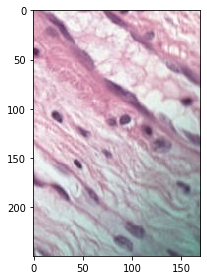

In [439]:
skimage.io.imshow(nonwhite_image_tiles[23])

In [426]:
nonwhite_image_tiles1 = nonwhite_image_tiles[:int(final_dim**2*final_ratio),:,:,:]

In [446]:
nonwhite_image_tiles1.shape
#mustbe (11776, 5888, 3)

(512, 250, 170, 3)

In [453]:
32*16

512

In [434]:
nonwhite_image_tiles1.size

65280000

In [435]:
28*56*150*100*3

70560000

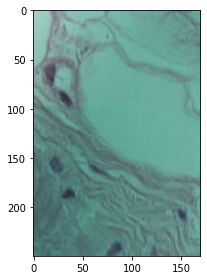

In [447]:
skimage.io.imshow(nonwhite_image_tiles1[25,:,:])

In [570]:
a, b, c, d = nonwhite_image_tiles1.shape

In [571]:
print(a, b, c, d)

512 250 170 3


In [574]:
data_new = (nonwhite_image_tiles1.reshape(32, 16, b, c, d).swapaxes(1,2).reshape(b*32, c*16, d))

In [575]:
data_new.shape

(8000, 2720, 3)

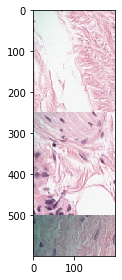

In [580]:
skimage.io.imshow(data_new[1000:1600, 1200:1400])

In [42]:
type(biopsy1)

numpy.ndarray

In [43]:
biopsy1.shape


(512, 512, 3)

In [17]:
type(biopsy.data)

numpy.ndarray

### 2.Take cancer areas with masks ###

In [ ]:
#these files were copied to local
#sample_arr = ['0587586b10cc3417c3c3607102b3f720', '031f5ef5b254fbacd6fbd279ebfe5cc0', '00928370e2dfeb8a507667ef1d4efcbb',
#'00c15b23b30a5ba061358d9641118904, 0018ae58b01bdadc8e347995b69f99aa, 001c62abd11fa4b57bf7a6c603a11bb9,
# '008069b542b0439ed69b194674051964','00a97615a51ba4c475bdec8505623bf9', '0068d4c7529e34fd4c9da863ce01a161',
# '006f6aa35a78965c92fffd1fbd53a058', '010f9df31ea44191c106d8226eaf46fb', '01c977c97e2f5543e65e559d98dec93c',
# '00bbc1482301d16de3ff63238cfd0b34', '018eabc8f4503ab89d0725b430e4808f', '00d7ec94436e3a1416a3b302914957d3',
# '01065a75c0dfd95f78893ebbfd3c70b3', '003046e27c8ead3e3db155780dc5498e', '0032bfa835ce0f43a92ae0bbab6871cb',
# '004dd32d9cd167d9cc31c13b704498af', '00c46b336b5b06423fcdec1b4d5bee06', '0005f7aaab2800f6170c399693a96917',
# '000920ad0b612851f8e01bcc880d9b3d', '02a3870e56dbcb6afd73546af54a8457', '0325d6b779870b7bd216f3a81f6ab3d7']